In [1]:
from sklearn.datasets import fetch_openml

In [2]:
mnist=fetch_openml('mnist_784', version=1,as_frame=False)

In [3]:
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [4]:
X= mnist['data']
y= mnist['target']

In [5]:
X.shape

(70000, 784)

In [6]:
y.shape

(70000,)

In [7]:
# There are 70000 pictures, with a 28x28 dimensions

In [8]:
import matplotlib.pyplot as plt
import matplotlib as mpl

In [9]:
some_digit=X[0]

In [10]:
some_digit_image= some_digit.reshape(28,28)

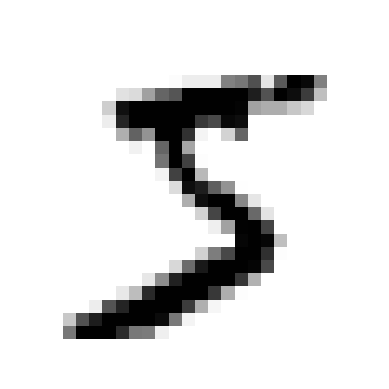

In [11]:
plt.imshow(some_digit_image, cmap=mpl.cm.binary, interpolation="nearest")
plt.axis("off")
plt.show()

In [12]:
import numpy as np
y=y.astype(np.uint8)

In [13]:
X_train, X_test, y_train, y_test= X[:60000], X[60000:], y[:60000], y[60000:]

In [14]:
# Binary classifier to predict 5 and non 5

In [15]:
y_train_5= (y_train==5)
y_test_5= (y_test==5)

In [16]:
from sklearn.linear_model import SGDClassifier
sgd_clf=SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [17]:
# This model has been pickled
# import pickle
# sgd_clf= pickle.load(open('SGC_model.sav', 'rb'))

In [18]:
sgd_clf.predict([some_digit])

array([ True])

In [19]:
# Measure performance

In [20]:
# Custom cross validation
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

In [21]:
skfolds= StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf= clone(sgd_clf)
    X_train_folds= X_train[train_index]
    y_train_folds= y_train_5[train_index]
    X_test_folds= X_train[test_index]
    y_test_folds= y_train_5[test_index]    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred= clone_clf.predict(X_test_folds)
    n_correct= sum(y_pred==y_test_folds)
    print(n_correct/len(y_pred))

0.9669
0.91625
0.96785


In [22]:
from sklearn.model_selection import cross_val_score


In [23]:
cross_val_score(sgd_clf,X_train, y_train_5, cv=3, scoring='accuracy')

array([0.95035, 0.96035, 0.9604 ])

In [24]:
# Too absurd perhaps? Let's try on a simple model and predict non-5

from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X),1), dtype=bool)

In [25]:
never_5_clf= Never5Classifier()
cross_val_score(never_5_clf,X_train, y_train_5, cv=3, scoring='accuracy')

array([0.91125, 0.90855, 0.90915])

In [26]:
# This means that the model can predict non-5 value 90% of the time. Too absurd since 10% of the entire model is 5

In [27]:
# Use confusion matrix to evaluate the model
# First we need prediction to compare to the actual target. This calls for cross_val_predict

from sklearn.model_selection import cross_val_predict


In [28]:
y_train_pred=cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [29]:
from sklearn.metrics import confusion_matrix


In [30]:
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

In [31]:
# Learn more about precision

In [32]:
# Let's pickle the SGD model
import pickle
# file_name= 'SGC_model.sav'
# pickle.dump(sgd_clf, open(file_name, 'wb'))

In [33]:
from sklearn.metrics import precision_score, recall_score

In [34]:
precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [35]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

In [36]:
# Let's check for f1_score
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343846

In [37]:
# However, we must remember that there is a trade off between precision and recall. Example higher precision prediction means that you need to eliminate any chance of having potential good results. and vice versa

In [38]:
# We can adjust the threshold. Higher means better precision and vice versa

In [39]:
y_scores=sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [40]:
threshold=0

y_some_digit_pred=(y_scores>threshold)
y_some_digit_pred

array([ True])

In [41]:
threshold=8000
y_some_digit_pred=(y_scores>threshold)
y_some_digit_pred

array([False])

In [42]:
# We will never sure to find a good threshold. But we can use cross_val_predict to get the threshold

y_scores= cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method='decision_function')

In [43]:
y_scores

array([  1200.93051237, -26883.79202424, -33072.03475406, ...,
        13272.12718981,  -7258.47203373, -16877.50840447])

In [44]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

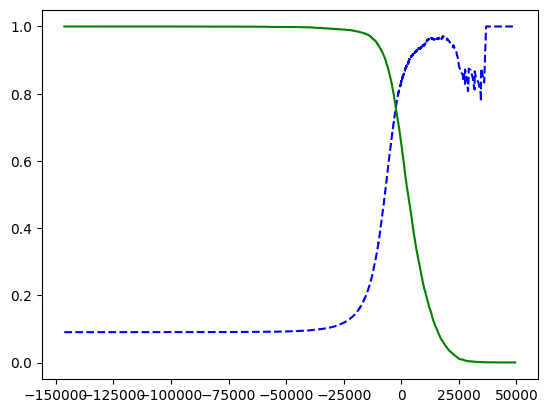

In [45]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

In [46]:
# As you can see the debate between precision and recall are inverse related. Therefor, when someone ask to have a 99% prediction rate, ask also for at what recall

In [47]:
# ROC curve
# Another way to measure the model's performance is the ROC curve. Essentially, ROC curves shows the differences between True positive rate (recall) and True negative rate (specificity)
from sklearn.metrics import roc_curve


In [48]:
fpr, tpr, thresholds= roc_curve(y_train_5, y_scores)

In [49]:
def plot_roc_curve(fpr, tpr, labels=None):
    plt.plot(fpr,tpr, linewidth=2, label=labels)
    plt.plot([0,1],[0,1],'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")

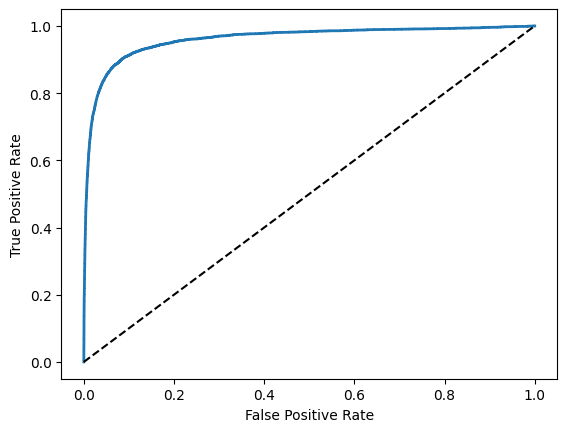

In [50]:
plot_roc_curve(fpr,tpr)

In [51]:
plt.show()

In [52]:
from sklearn.metrics import roc_auc_score

In [53]:
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

In [54]:
# Let's try a different model, Random Forest Classifier and compare the ROC score with the SGD classifier
from sklearn.ensemble import RandomForestClassifier

In [55]:
rfc_clf= RandomForestClassifier(random_state=42)
y_probas_forest= cross_val_predict(rfc_clf, X_train, y_train_5, cv=3, method="predict_proba")

In [56]:
y_scores_forest= y_probas_forest[:,1]
fpr_forest, tpr_forest, forest_threshold= roc_curve(y_train_5, y_scores_forest)

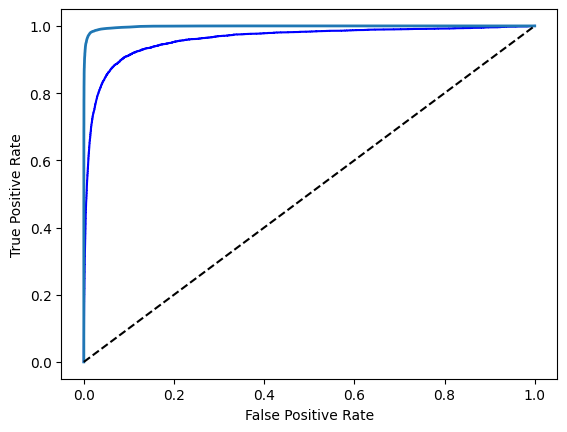

In [57]:
plt.plot(fpr,tpr, "b", label="SDG")
plot_roc_curve(fpr_forest, tpr_forest, labels="Forest_CLF")
plt.show()

In [58]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

In [59]:
# Multiclass Classification
# In many cases, user can define to have a multiclass function. Models that support multiclass function are RFC, Naive Bayes and others such as SVM, Linear classifcation are stricly binary classfier

In [60]:
# There are 2 strategy that use in Multiclass
# One v All: Example, we'll create a 10 value classifier. So we evaluate the scores of each value classifer, which has the highest scores will produce the result
# One v One: Same example. Train a binary classfier for each pair of unit (eg: 0v2, 1v2,3v0, etc). In total, if we have N values, we need to train N*(N-1)/2. 

In [61]:
# Let's make a multivalue classifier with RandomForestClassifier
# Sklearn will evaluate for us

sgd_clf.fit(X_train[:1000], y_train[:1000])

SGDClassifier(random_state=42)

In [62]:
sgd_clf.predict([some_digit])

array([5], dtype=uint8)

In [63]:
some_digit_scores= sgd_clf.decision_function([some_digit])
some_digit_scores


array([[-6049581.97985829, -6138036.45541781, -3886281.38604606,
         -604692.42366776, -6948311.32017537,   914498.2913215 ,
        -6855666.78647961, -3866146.33271573, -4016434.08430155,
        -3209136.89074954]])

In [64]:
np.argmax(some_digit_scores)

5

In [65]:
sgd_clf.classes_[5]

5

In [66]:
# We can force sklearn to do OvO strategy
from sklearn.multiclass import OneVsOneClassifier

In [67]:
ovo_clf=OneVsOneClassifier(SGDClassifier(random_state=42))
ovo_clf.fit(X_train, y_train)

OneVsOneClassifier(estimator=SGDClassifier(random_state=42))

In [68]:
ovo_clf.predict([some_digit])

array([5], dtype=uint8)

In [69]:
len(ovo_clf.estimators_)

45

In [70]:
rfc_clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [71]:
rfc_clf.predict([some_digit])

array([5], dtype=uint8)

In [72]:
rfc_clf.predict_proba([some_digit])

array([[0.  , 0.  , 0.01, 0.08, 0.  , 0.9 , 0.  , 0.  , 0.  , 0.01]])

In [73]:
# Now let's evaluate the model's accuracy

In [74]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

In [75]:
# We can do better than this. Let's start with standard Scaler. Which will ensure that the machine see the inputs as only value and contains no meaning

In [76]:
from sklearn.preprocessing import StandardScaler

In [77]:
scaler=StandardScaler()
X_train_scaled= scaler.fit_transform(X_train.astype(np.float64))

In [78]:
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.8983, 0.891 , 0.9018])

In [79]:
# For linear classifier, it's best to scale the value with Standard Scaler to get better overall accuracy score?

In [80]:
# Error analysis

In [81]:
y_train_pred= cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)

In [82]:
conf_mx= confusion_matrix(y_train, y_train_pred)

In [83]:
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]],
      dtype=int64)

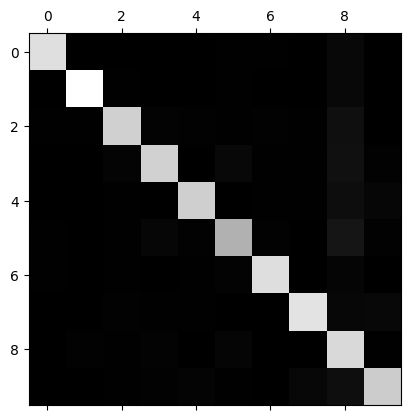

In [84]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

In [85]:
# We can see that overall, most of the predictions are on point. Except for 5,1 ,10. These are slightly weeaker than the rest

In [86]:
# Let's look onto the errors

In [87]:
row_sums= conf_mx.sum(axis=1, keepdims=True)

In [88]:
norm_conf_mx= conf_mx/row_sums

In [89]:
np.fill_diagonal(norm_conf_mx, 0)

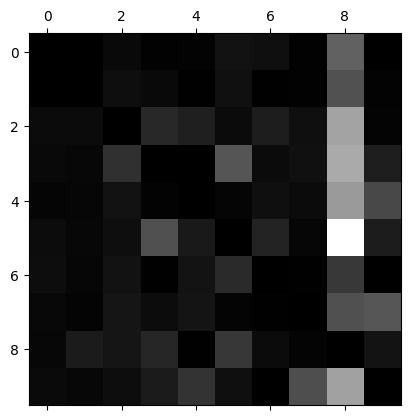

In [90]:
plt.matshow(norm_conf_mx, cmap= plt.cm.gray)
plt.show()

In [91]:
# There are a lot of miss prediction between 5 and 8 and 3 and 8. However, look at roth 8th, we can see that the prediciton of 8 for 8 is actually correct most of the time

In [92]:
# What we can do is to get more data of 5 and 3, or perhaps create a model to predict the close loops (eg. 8 has 2, 6 has 1, 5 has none, etc)


In [93]:
# Or preprocess the model?

In [95]:
from sklearn.neighbors import KNeighborsClassifier

In [96]:
y_train_large=(y_train>=7)
y_train_odd=(y_train % 2==1)

In [97]:
y_multilabel= np.c_[y_train_large, y_train_odd]

In [98]:
knn_clf=KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [99]:
knn_clf.predict([some_digit])

array([[False,  True]])

In [100]:
# Make sense 5 is small than 7 and an odd number

In [102]:
#Let's evaluate the f1-score of this model

y_train_knn_pred=cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)

In [104]:
f1_score(y_multilabel, y_train_knn_pred, average='weighted')

0.9778357403921755

In [105]:
# Multioutput classifcation

In [112]:
noise= np.random.randint(0,100, (len(X_train), 784))
X_train_mod= X_train+noise
noise_test= np.random.randint(0,100, (len(X_test), 784))
X_test_mod= X_test+noise_test
y_train_mod= X_train
y_test_mod= X_test

In [113]:
# Let's make the prediction of the clean image

In [114]:
knn_clf.fit(X_train_mod, y_train_mod)

KNeighborsClassifier()

In [117]:
clean_digit=knn_clf.predict([X_test_mod[0]])

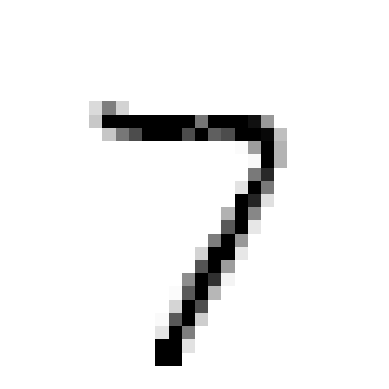

In [121]:
clean_digit_image= clean_digit.reshape(28,28)
plt.imshow(clean_digit_image, cmap=mpl.cm.binary, interpolation="nearest")
plt.axis("off")
plt.show()

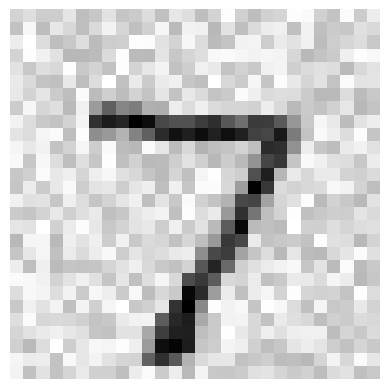

In [123]:
noise_image=X_test_mod[0]
noise_image= noise_image.reshape(28,28)
plt.imshow(noise_image, cmap=mpl.cm.binary, interpolation="nearest")
plt.axis("off")
plt.show()

In [15]:
from sklearn.neighbors import KNeighborsClassifier

In [16]:
knn_clf=KNeighborsClassifier()
knn_clf.fit(X_train, y_train)

KNeighborsClassifier()

In [17]:
y_test_preds=knn_clf.predict(X_test)

In [23]:
from sklearn.metrics import precision_score, recall_score, f1_score

In [21]:
precision_score(y_test, y_test_preds, average='macro')

0.9692753386570571

In [22]:
recall_score(y_test, y_test_preds, average='macro')

0.9684705010297703

In [24]:
f1_score(y_test, y_test_preds, average='macro')

0.9687143421292884

In [25]:
from sklearn.model_selection import GridSearchCV

In [34]:
param_grid=[
    {'n_neighbors':[5,7,10], 'weights':['uniform','distance']}]

grid_search= GridSearchCV(knn_clf, param_grid, cv=3, scoring='accuracy', return_train_score=True)

grid_search.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=KNeighborsClassifier(),
             param_grid=[{'n_neighbors': [5, 7, 10],
                          'weights': ['uniform', 'distance']}],
             return_train_score=True, scoring='accuracy')

In [35]:
grid_search.best_params_

{'n_neighbors': 5, 'weights': 'distance'}

Data Augmentataion

In [37]:
from  scipy.ndimage import shift

In [51]:
def shift_image(image, dx, dy):
    image= image.reshape((28,28))
    shifted_image= shift(image, [dy,dx], cval=0, mode='constant')
    return shifted_image.reshape([-1])

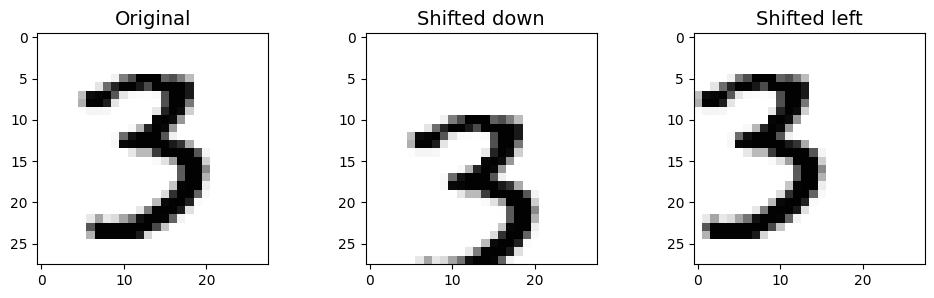

In [53]:
image=X_train[10000]
shift_left_image= shift_image(image,-5,0)
shift_down_image= shift_image(image,0,5)

plt.figure(figsize=(12,3))
plt.subplot(131)
plt.title("Original", fontsize=14)
plt.imshow(image.reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.subplot(132)
plt.title("Shifted down", fontsize=14)
plt.imshow(shift_down_image.reshape(28,28), interpolation="nearest", cmap="Greys")
plt.subplot(133)
plt.title("Shifted left", fontsize=14)
plt.imshow(shift_left_image.reshape(28,28), interpolation="nearest", cmap="Greys")
plt.show()

In [54]:
X_train_augmented=[image for image in X_train]
y_train_augmented=[label for label in y_train]

In [59]:
for dx,dy in ((1,0),(0,1),(-1,0),(0,-1)):
    for image, label in zip(X_train, y_train):
        X_train_augmented.append(shift_image(image,dx, dy))
        y_train_augmented.append(label)
        
X_train_augmented=np.array(X_train_augmented)
y_train_augmented=np.array(y_train_augmented)

In [60]:
shuffle_ids= np.random.permutation(len(X_train_augmented))
X_train_augmented= X_train_augmented[shuffle_ids]
y_train_augmented= y_train_augmented[shuffle_ids]

In [65]:
knn_clf_augmented=KNeighborsClassifier(**grid_search.best_params_)

In [66]:
knn_clf_augmented.fit(X_train_augmented, y_train_augmented)

KNeighborsClassifier(weights='distance')

In [68]:
from sklearn.metrics import accuracy_score
y_pred = knn_clf_augmented.predict(X_test)
accuracy_score(y_test, y_pred)

0.9761

Titanic model